# DGE analyses for **flower vs non-flower tissues** using `r-sleuth` in **wheat**
In this notebook, DGE-analyses for **flower vs all-other-tissues** are prepared:
 * 1. all vs flower based on dev.stages division: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues
         - `null = dataset+is_flower`
         - `full = dataset+is_flower[yes-no]+is_reproductive[yes-no]`
 * 2. all vs flower without dev.stages division (bc dev.stages assignment is still an arbitrary choice!):
     - `null = dataset`
     - `full = dataset+is_flower[yes-no]`
 * 3. all vs flower with adding Zadocs as time course series factor:
     - `null = dataset + zadoc_scale`
     - `full = dataset + zadoc_scale + is_flower[yes-no]`
 * 4. primordiums vs matured flower&stem&leaf&meristem tissues based on dev.stages -> 13-30Z yes vs 31-69Z no primordium stage:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`
 * 5. primordiums vs matured **flower** tissues based on dev.stages -> 13-30 flowers vs 31-69 flowers:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`

## Import and prepare data

In [1]:
library(sleuth, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(RColorBrewer, warn.conflicts = FALSE)
library(vsn)
library(pheatmap)
library(shiny)
theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLappl

In [2]:
set.seed(42) # For reproducibility of results

In [3]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
# stringsAsfactors has to be truse for deseq2 design
wheat_metadata <- read.table("wheat_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
wheat_meta <- select(wheat_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(wheat_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# exclude outliers detected during exploratory analyses: ERR781040, ERR1457187
wheat_meta <- filter(wheat_meta, ID != "ERR781040")
wheat_meta <- filter(wheat_meta, ID != "ERR1457187")
# exclude outliers detected during first sleuth runs: ERR1457171, ERR1457170, they are from developmental dataset, rachis/grain samples
wheat_meta <- filter(wheat_meta, ID != "ERR1457171")
wheat_meta <- filter(wheat_meta, ID != "ERR1457170")
# add rownames for deseq2 to identify rows with count-columns
rownames(wheat_meta) <- wheat_meta$ID
glimpse(wheat_meta)

Rows: 215
Columns: 22
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ batch               <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6…
$ cultivar            <chr> "303-B", "303-B", "303-B", "C303A", "C303A", "C30…
$ gm                  <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt"…
$ zadoc_scale         <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5…
$ intermediate_age    <chr> "Heading", "Heading", "Heading", "Heading", "Head…
$ high_level_age      <chr> "Reproductive", "Reproductive", "Reproductive", "…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ high_level_tissue   <chr> "inflorescence", "inflorescence", "inflorescence"…
$ treatment           <chr> "control", "control", "control", "mutant", "mutan…
$ rna_extraction      <chr> "trizol", "trizol", "trizol", "trizol", "trizol",…
$ rna_enrichment      <chr> "o

# 1. Flower contrast: **all vs flower based on dev.stages**
## 1.1 Create contrast variables
* **is_flower:** yes = inflorescence, no = all other tissue kinds
* **is_reproductive:** yes = reproductive stage, no = all other stages

In [4]:
b <- wheat_meta %>% mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                     mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                     mutate(is_flower = str_replace(is_flower, "FALSE", "no"))
wheat_flower1 <- b %>% mutate(is_reproductive = str_detect(high_level_age, "Reproductive")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "TRUE", "yes")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "FALSE", "no")) %>%
                    select(ID, dataset, is_flower, is_reproductive)
wheat_flower1$ID <- as.factor(wheat_flower1$ID)
wheat_flower1$dataset <- as.factor(wheat_flower1$dataset)
wheat_flower1$is_flower <- as.factor(wheat_flower1$is_flower)
wheat_flower1$is_reproductive <- as.factor(wheat_flower1$is_reproductive)
glimpse(wheat_flower1)
tail(wheat_flower1, 3)

Rows: 215
Columns: 4
$ ID              <fct> SRR10737427, SRR10737428, SRR10737429, SRR10737430, S…
$ dataset         <fct> cytoplasmic_male_sterility, cytoplasmic_male_sterilit…
$ is_flower       <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
$ is_reproductive <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…


ID         dataset                is_flower is_reproductive
213 SRR5186382 chlorophyll_deficiency no        no             
214 SRR5186387 chlorophyll_deficiency no        no             
215 SRR5186416 chlorophyll_deficiency no        no

In [5]:
t <- wheat_flower1 %>% filter(is_flower == "yes") %>% filter(is_reproductive == "yes")
glimpse(t)
t1 <- wheat_flower1 %>% filter(is_flower == "no") %>% filter(is_reproductive == "no")
glimpse(t1)
# 34 samples are flower but not in reproductive stage
# 31 samples are not flower but are in reproductive stage
# keeping 82 + 91 samples to contrast:
#flower1 <- bind_rows(t, t1)
#glimpse(flower1)

Rows: 127
Columns: 4
$ ID              <fct> SRR10737427, SRR10737428, SRR10737429, SRR10737430, S…
$ dataset         <fct> cytoplasmic_male_sterility, cytoplasmic_male_sterilit…
$ is_flower       <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
$ is_reproductive <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
Rows: 41
Columns: 4
$ ID              <fct> ERR424721, ERR424726, ERR424728, ERR424730, ERR424734…
$ dataset         <fct> dev_timecourse_series, dev_timecourse_series, dev_tim…
$ is_flower       <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ is_reproductive <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…


## 1.2 Normalization with reduced + full modells: Variance Stabilization on raw TPM counts
* based on all the exploratory analysis 2(+1) main technical variables are majorly responsible for the clustering of the counts: `dataset`, `library` and `instrument`
* these 3 variables has to go to the design matrix: as their numbering and division borders are the same, `dataset` alone covers for all of them, and including all would cause linearity in the model
* source: https://pachterlab.github.io/sleuth/about

In [56]:
# load tx2gene object for mRNA mapping information
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
m <- read.delim("wheat_tx2gene.tsv",stringsAsFactors=FALSE)
colnames(m) <- c("target_id", "gene")
head(m, 3)
dim(m)

target_id             gene               
1 TraesCHI1A01G000600.1 TraesCHI1A01G000600
2 TraesCHI1A01G000800.1 TraesCHI1A01G000800
3 TraesCHI1A01G001100.1 TraesCHI1A01G001100

[1] 123075      2

## 1.3 Filtering out NA values
* in the first sleuth round these genes were reported as having NA values and blocked the further analysis: Horvu_MOREX_1H01G070600, Horvu_MOREX_5H01G674500
* another run gave these: Horvu_MOREX_2H01G239500, Horvu_MOREX_4H01G531500

In [9]:
# sleuth gives warning of these genes but not crucial to filter them!! also every iteration warned against another pair of genes..
#m_filt <- m %>% filter(gene != "Horvu_MOREX_2H01G239500")
#m_filt <- m_filt %>% filter(gene != "Horvu_MOREX_4H01G531500")
#dim(m_filt)

In [57]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", wheat_meta$ID, "abundance.h5")
names(files) <- paste0(wheat_meta$ID)
head(files)
all(file.exists(files))

SRR10737427 
"../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5" 
                                                 SRR10737428 
"../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5" 
                                                 SRR10737429 
"../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5" 
                                                 SRR10737430 
"../04_Kallisto_allreads_symlinked/SRR10737430/abundance.h5" 
                                                 SRR10737431 
"../04_Kallisto_allreads_symlinked/SRR10737431/abundance.h5" 
                                                 SRR10737432 
"../04_Kallisto_allreads_symlinked/SRR10737432/abundance.h5"

[1] TRUE

In [11]:
s2c_flower1 <- mutate(wheat_flower1, path = files, sample = ID)
head(s2c_flower1, 3)

ID          dataset                    is_flower is_reproductive
1 SRR10737427 cytoplasmic_male_sterility yes       yes            
2 SRR10737428 cytoplasmic_male_sterility yes       yes            
3 SRR10737429 cytoplasmic_male_sterility yes       yes            
  path                                                       sample     
1 ../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5 SRR10737427
2 ../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5 SRR10737428
3 ../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5 SRR10737429

In [12]:
# construct the sleuth-object
so_flower1 <- sleuth_prep(sample_to_covariates = s2c_flower1, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.......................................................................................................................................................................................................................
normalizing est_counts
60721 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60721 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
..................................................
................


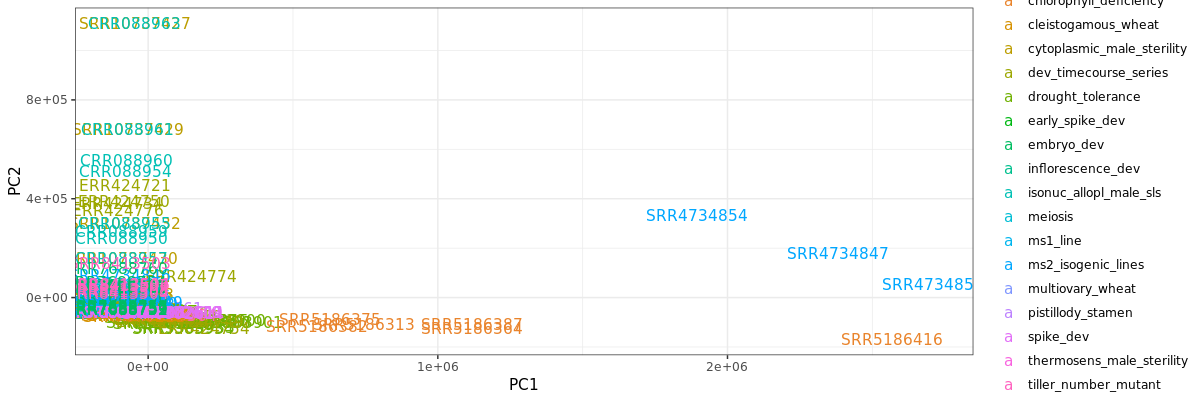

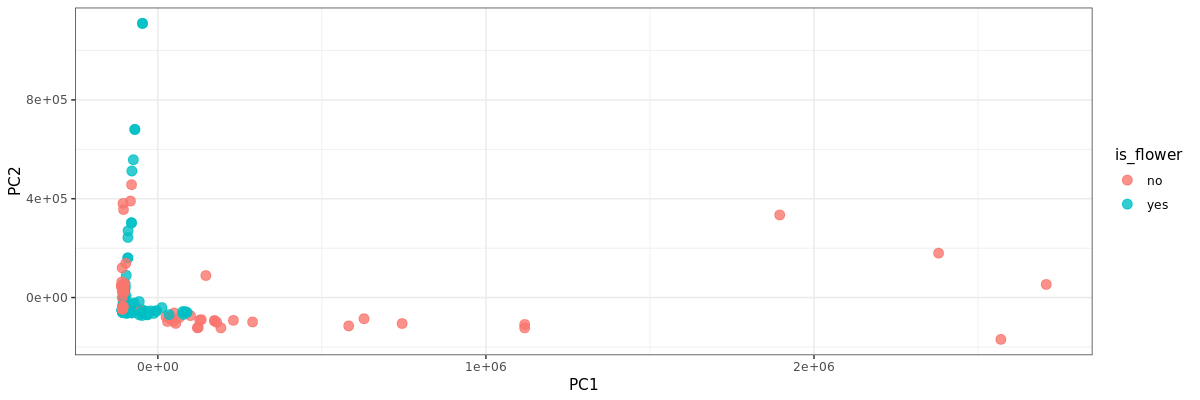

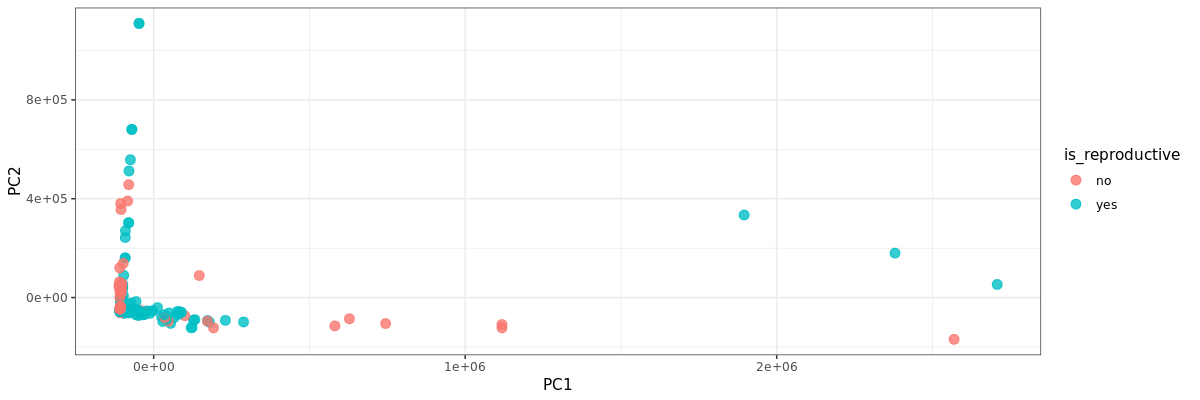

In [13]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower1, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower1, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_flower1, color_by = 'is_reproductive',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [15]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
#plot_bootstrap(so_flower1, 'Horvu_MOREX_7H01G200700', color_by = 'is_flower',units='scaled_reads_per_base')

In [16]:
# create models
so_flower1 <- sleuth_fit(so_flower1, ~dataset + is_flower + is_reproductive, 'full')
so_flower1 <- sleuth_fit(so_flower1, ~dataset + is_flower, 'reduced')

fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI5B01G387700, TraesCHI7A01G042000, TraesCHI7A01G571100
computing variance of betas
fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI5B01G387700, TraesCHI7A01G042000, TraesCHI7A01G571100
computing variance of betas


In [17]:
# perform DGE test
so_flower1 <- sleuth_lrt(so_flower1, 'reduced', 'full')

In [18]:
models(so_flower1)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetmultiovary_wheat
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasetthermosens_male_sterility
 	datasettiller_number_mutant
 	datasettranscriptfc_q_mutant
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset + is_flower 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datas

In [19]:
table_flower1 <- sleuth_results(so_flower1, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower1_1 <- filter(table_flower1, qval <= 0.1)
glimpse(sig_flower1_1)
sig_flower1_05 <- filter(table_flower1, qval <= 0.05)
glimpse(sig_flower1_05)
sig_flower1_01 <- filter(table_flower1, qval <= 0.01)
glimpse(sig_flower1_01)
# look at table and few of 0.05
head(sig_flower1_05, 5)

Rows: 27,419
Columns: 12
$ target_id       <chr> "TraesCHI6B01G160800", "TraesCHI5A01G248900", "TraesC…
$ pval            <dbl> 3.215407e-29, 2.123664e-21, 4.155607e-21, 1.144995e-2…
$ qval            <dbl> 1.952427e-24, 6.447549e-17, 8.411087e-17, 1.738131e-1…
$ test_stat       <dbl> 125.91129, 90.22680, 88.89868, 86.89394, 82.93743, 82…
$ rss             <dbl> 62.17447, 25.04654, 415.90043, 62.24492, 66.63289, 31…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 5.396701, 6.604458, 2.132492, 5.978212, 5.618846, 2.4…
$ var_obs         <dbl> 1.2682467, 0.3490862, 5.7161447, 0.8467173, 1.0773142…
$ tech_var        <dbl> 0.026799890, 0.002060421, 0.164240379, 0.009091378, 0…
$ sigma_sq        <dbl> 0.2920436, 0.1263834, 1.9685824, 0.3101133, 0.3317100…
$ smooth_sigma_sq <dbl> 0.10615313, 0.08240387, 0.61016308, 0.08868084, 0.097…
$ final_sigma_sq  <dbl> 0.2920436, 0.1263834, 1.9685824, 0.3101133, 0.3317100…
Rows: 17,793
Columns: 12
$ 

target_id           pval         qval         test_stat rss      
1 TraesCHI6B01G160800 3.215407e-29 1.952427e-24 125.91129  62.17447
2 TraesCHI5A01G248900 2.123664e-21 6.447549e-17  90.22680  25.04654
3 TraesCHIUn01G184500 4.155607e-21 8.411087e-17  88.89868 415.90043
4 TraesCHI6D01G110700 1.144995e-20 1.738131e-16  86.89394  62.24492
5 TraesCHI6A01G124900 8.469209e-20 1.028518e-15  82.93743  66.63289
  degrees_free mean_obs var_obs   tech_var    sigma_sq  smooth_sigma_sq
1 1            5.396701 1.2682467 0.026799890 0.2920436 0.10615313     
2 1            6.604458 0.3490862 0.002060421 0.1263834 0.08240387     
3 1            2.132492 5.7161447 0.164240379 1.9685824 0.61016308     
4 1            5.978212 0.8467173 0.009091378 0.3101133 0.08868084     
5 1            5.618846 1.0773142 0.009997102 0.3317100 0.09770903     
  final_sigma_sq
1 0.2920436     
2 0.1263834     
3 1.9685824     
4 0.3101133     
5 0.3317100

In [20]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig_flower1_1, file = "deg_wheat_flower1_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower1_05, file = "deg_wheat_flower1_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower1_01, file = "deg_wheat_flower1_signif0_01.csv", sep = ",", col.names = TRUE)

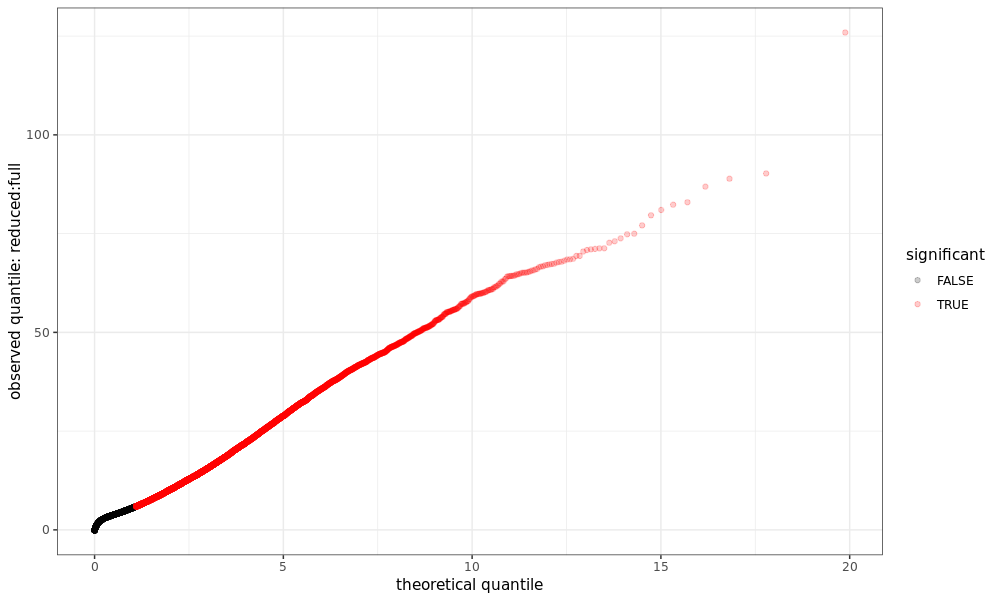

In [21]:
plot_qq(so_flower1, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

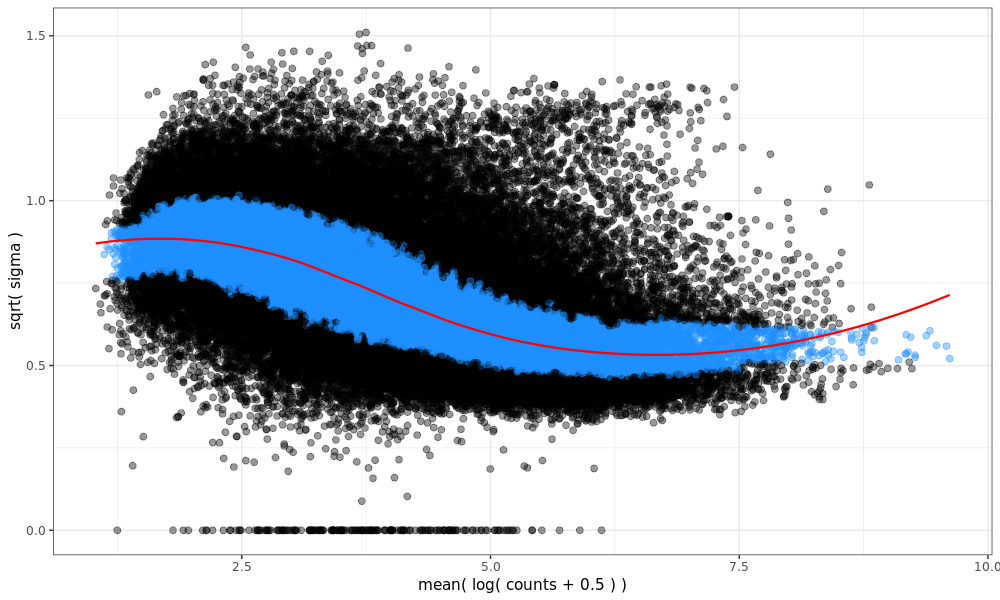

In [22]:
plot_mean_var(so_flower1,which_model="full")

# 2. Flower contrast: **all vs flower without dev.stages**
 * bc dev.stages assignment is still an arbitrary choice!
     - `null = dataset`
     - `full = dataset+is_flower[yes-no]`

## 2.1 Contrast variables
* **is_flower:** yes = inflorescence, no = all other tissue kinds

In [23]:
wheat_flower2 <- wheat_meta %>% mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                     mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                     mutate(is_flower = str_replace(is_flower, "FALSE", "no")) %>%
                    select(ID, dataset, is_flower)
wheat_flower2$ID <- as.factor(wheat_flower2$ID)
wheat_flower2$dataset <- as.factor(wheat_flower2$dataset)
wheat_flower2$is_flower <- as.factor(wheat_flower2$is_flower)
glimpse(wheat_flower2)
tail(wheat_flower2, 3)

Rows: 215
Columns: 3
$ ID        <fct> SRR10737427, SRR10737428, SRR10737429, SRR10737430, SRR1073…
$ dataset   <fct> cytoplasmic_male_sterility, cytoplasmic_male_sterility, cyt…
$ is_flower <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes,…


ID         dataset                is_flower
213 SRR5186382 chlorophyll_deficiency no       
214 SRR5186387 chlorophyll_deficiency no       
215 SRR5186416 chlorophyll_deficiency no

## 2.2 Filtering NA values
(not crucial!)

In [24]:
#m_filt <- m %>% filter(gene != "Horvu_MOREX_2H01G239500")
#m_filt <- m_filt %>% filter(gene != "Horvu_MOREX_4H01G531500")
#dim(m_filt)

In [32]:
s2c_flower2 <- mutate(wheat_flower2, path = files, sample = ID)
head(s2c_flower2, 3)

ID          dataset                    is_flower
1 SRR10737427 cytoplasmic_male_sterility yes      
2 SRR10737428 cytoplasmic_male_sterility yes      
3 SRR10737429 cytoplasmic_male_sterility yes      
  path                                                       sample     
1 ../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5 SRR10737427
2 ../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5 SRR10737428
3 ../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5 SRR10737429

In [33]:
# construct the sleuth-object
so_flower2 <- sleuth_prep(sample_to_covariates = s2c_flower2, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.......................................................................................................................................................................................................................
normalizing est_counts
60721 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60721 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
..................................................
................


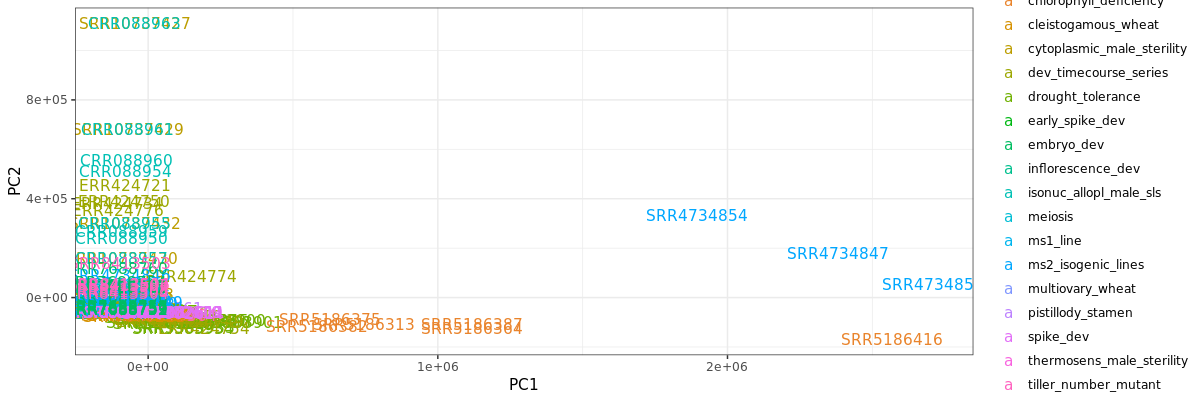

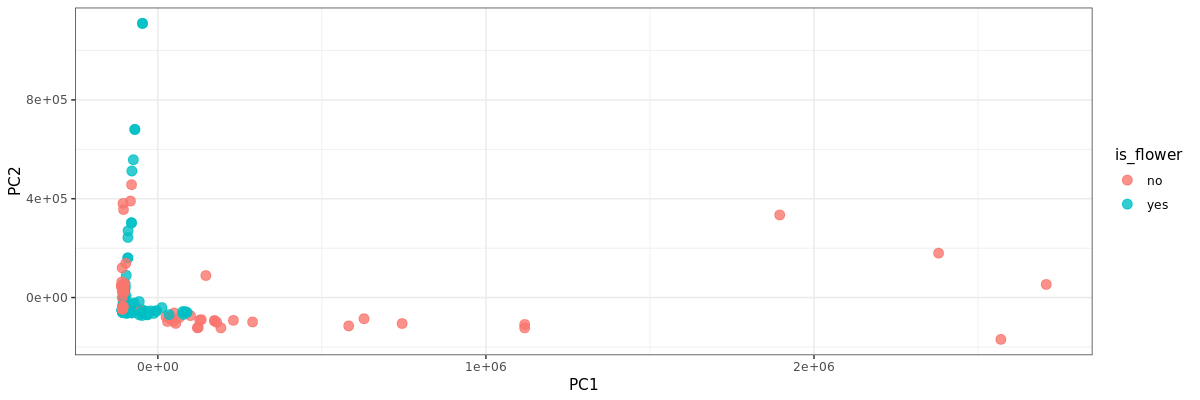

In [34]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower2, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower2, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [35]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
#plot_bootstrap(so_flower2, 'Horvu_MOREX_7H01G200700', color_by = 'is_flower',units='scaled_reads_per_base')

In [46]:
# create models
so_flower2 <- sleuth_fit(so_flower1, ~dataset + is_flower, 'full')
so_flower2 <- sleuth_fit(so_flower1, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI5B01G387700, TraesCHI7A01G042000, TraesCHI7A01G571100
computing variance of betas
fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI5B01G387700, TraesCHI7A01G571100
computing variance of betas


In [47]:
# perform DGE test
so_flower2 <- sleuth_lrt(so_flower2, 'reduced', 'full')

In [48]:
models(so_flower2)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetmultiovary_wheat
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasetthermosens_male_sterility
 	datasettiller_number_mutant
 	datasettranscriptfc_q_mutant
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetembryo_dev
 	datasetinfloresce

In [49]:
table_flower2 <- sleuth_results(so_flower2, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower2_1 <- filter(table_flower2, qval <= 0.1)
glimpse(sig_flower2_1)
sig_flower2_05 <- filter(table_flower2, qval <= 0.05)
glimpse(sig_flower2_05)
sig_flower2_01 <- filter(table_flower2, qval <= 0.01)
glimpse(sig_flower2_01)
# look at table and few of 0.05
head(sig_flower2_05, 5)

Rows: 54,877
Columns: 12
$ target_id       <chr> "TraesCHIUn01G110900", "TraesCHI3B01G024900", "TraesC…
$ pval            <dbl> 5.520671e-35, 2.540970e-32, 1.308705e-32, 2.505754e-3…
$ qval            <dbl> 3.352207e-30, 3.857256e-28, 3.857256e-28, 3.857256e-2…
$ test_stat       <dbl> 157.7640, 145.5004, 146.8274, 145.5283, 143.6859, 139…
$ rss             <dbl> 136.16755, 140.03377, 189.60538, 293.90628, 132.73526…
$ degrees_free    <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ mean_obs        <dbl> 4.455256, 6.433371, 3.583370, 4.125637, 4.890934, 3.6…
$ var_obs         <dbl> 1.9784279, 1.2286068, 1.6487791, 3.2621715, 1.2272004…
$ tech_var        <dbl> 0.028873822, 0.004147606, 0.067632915, 0.039322616, 0…
$ sigma_sq        <dbl> 0.6658586, 0.7103104, 0.8997415, 1.4601992, 0.6466694…
$ smooth_sigma_sq <dbl> 0.19403280, 0.08668141, 0.35716402, 0.24447511, 0.146…
$ final_sigma_sq  <dbl> 0.6658586, 0.7103104, 0.8997415, 1.4601992, 0.6466694…
Rows: 52,603
Columns: 12
$ 

target_id           pval         qval         test_stat rss      degrees_free
1 TraesCHIUn01G110900 5.520671e-35 3.352207e-30 157.7640  136.1676 2           
2 TraesCHI3B01G024900 2.540970e-32 3.857256e-28 145.5004  140.0338 2           
3 TraesCHI3D01G495700 1.308705e-32 3.857256e-28 146.8274  189.6054 2           
4 TraesCHI7D01G554200 2.505754e-32 3.857256e-28 145.5283  293.9063 2           
5 TraesCHI1D01G179800 6.295112e-32 7.644910e-28 143.6859  132.7353 2           
  mean_obs var_obs  tech_var    sigma_sq  smooth_sigma_sq final_sigma_sq
1 4.455256 1.978428 0.028873822 0.6658586 0.19403280      0.6658586     
2 6.433371 1.228607 0.004147606 0.7103104 0.08668141      0.7103104     
3 3.583370 1.648779 0.067632915 0.8997415 0.35716402      0.8997415     
4 4.125637 3.262172 0.039322616 1.4601992 0.24447511      1.4601992     
5 4.890934 1.227200 0.030551309 0.6466694 0.14609348      0.6466694

In [50]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig_flower2_1, file = "deg_wheat_flower2_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower2_05, file = "deg_wheat_flower2_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower2_01, file = "deg_wheat_flower2_signif0_01.csv", sep = ",", col.names = TRUE)

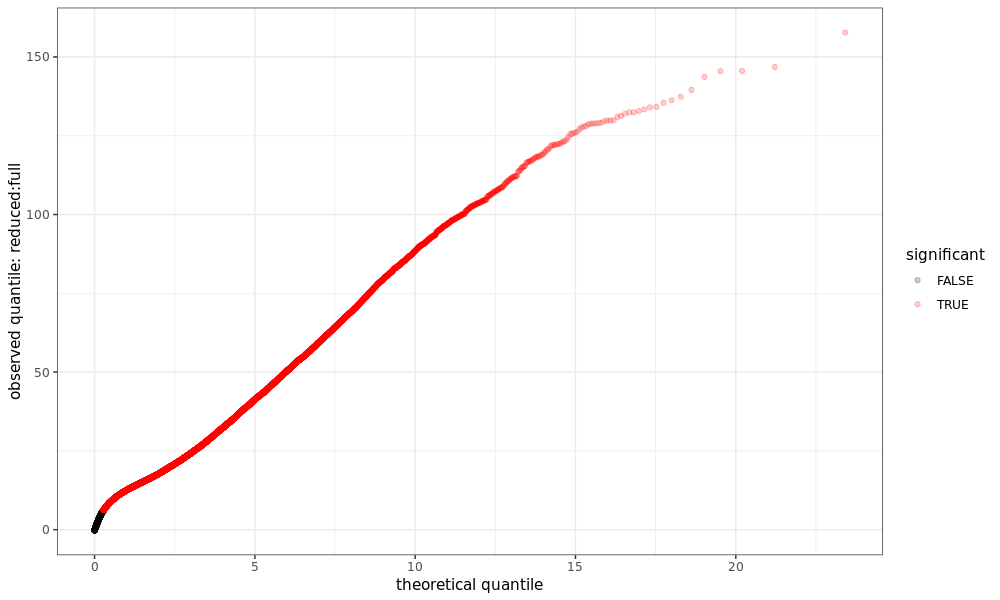

In [51]:
plot_qq(so_flower2, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

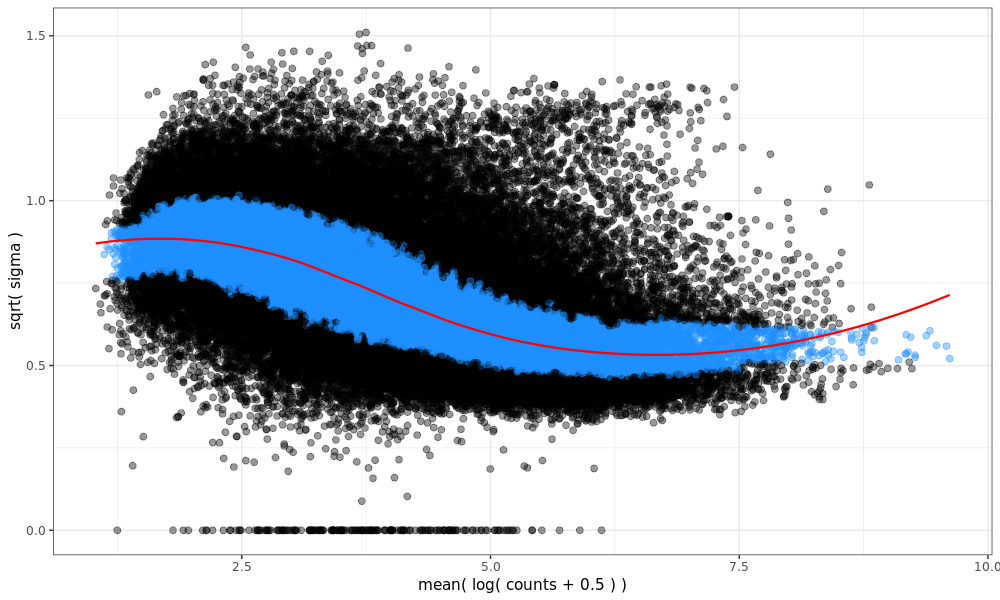

In [52]:
plot_mean_var(so_flower2,which_model="full")

# 3. Flower contrast: **all vs flower with Zadocs as time course series factor**
## 3.1 Create contrast variables
 * modells:
     - `null = dataset + Zadoc-scale`
     - `full = dataset + Zadoc-scale + is_flower[yes-no]`

In [53]:
wheat_flower3 <- wheat_meta %>% mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                     mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                     mutate(is_flower = str_replace(is_flower, "FALSE", "no")) %>%
                    select(ID, dataset, zadoc_scale, is_flower)
wheat_flower3$ID <- as.factor(wheat_flower3$ID)
wheat_flower3$dataset <- as.factor(wheat_flower3$dataset)
wheat_flower3$is_flower <- as.factor(wheat_flower3$is_flower)
wheat_flower3$zadoc_scale <- as.factor(wheat_flower3$zadoc_scale)
glimpse(wheat_flower3)
tail(wheat_flower3, 3)

Rows: 215
Columns: 4
$ ID          <fct> SRR10737427, SRR10737428, SRR10737429, SRR10737430, SRR10…
$ dataset     <fct> cytoplasmic_male_sterility, cytoplasmic_male_sterility, c…
$ zadoc_scale <fct> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5…
$ is_flower   <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, ye…


ID         dataset                zadoc_scale is_flower
213 SRR5186382 chlorophyll_deficiency 21          no       
214 SRR5186387 chlorophyll_deficiency 21          no       
215 SRR5186416 chlorophyll_deficiency 21          no

In [58]:
s2c_flower3 <- mutate(wheat_flower3, path = files, sample = ID)
head(s2c_flower3, 3)

ID          dataset                    zadoc_scale is_flower
1 SRR10737427 cytoplasmic_male_sterility 56          yes      
2 SRR10737428 cytoplasmic_male_sterility 56          yes      
3 SRR10737429 cytoplasmic_male_sterility 56          yes      
  path                                                       sample     
1 ../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5 SRR10737427
2 ../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5 SRR10737428
3 ../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5 SRR10737429

In [59]:
# construct the sleuth-object
so_flower3 <- sleuth_prep(sample_to_covariates = s2c_flower3, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.......................................................................................................................................................................................................................
normalizing est_counts
60721 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60721 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
..................................................
................


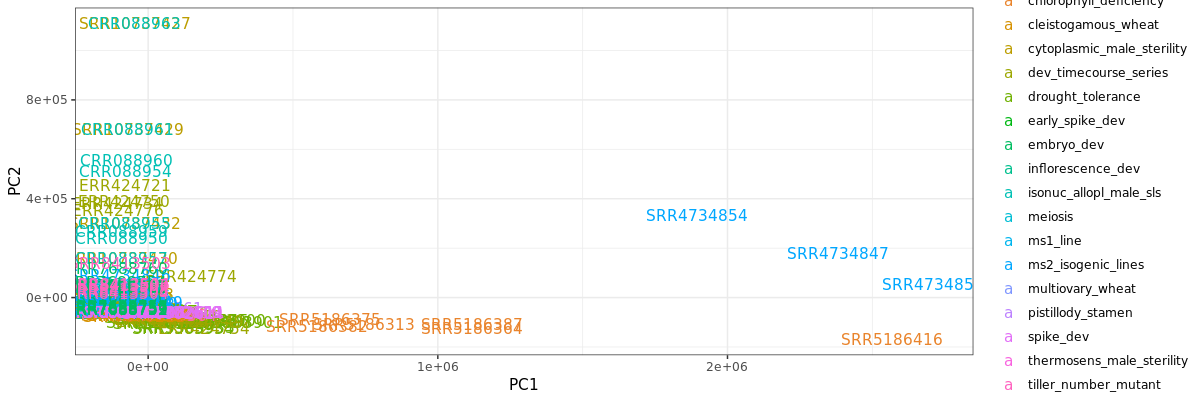

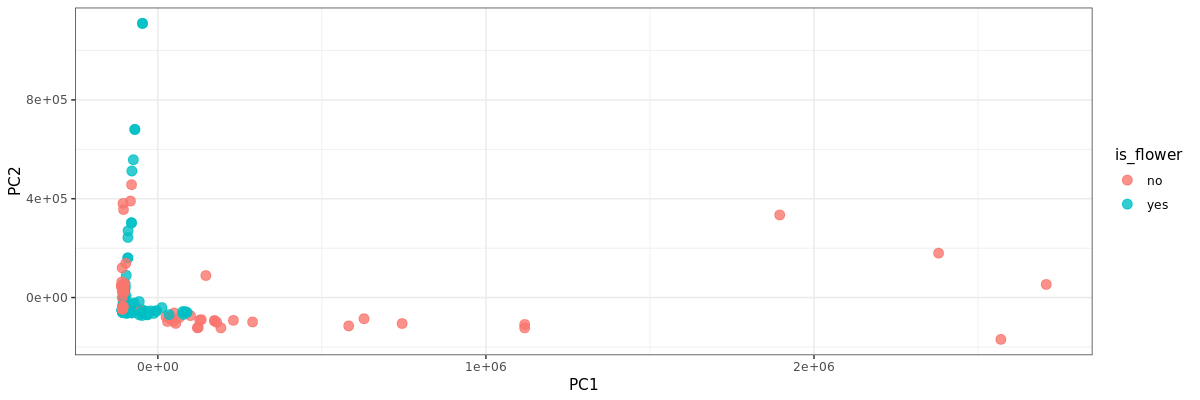

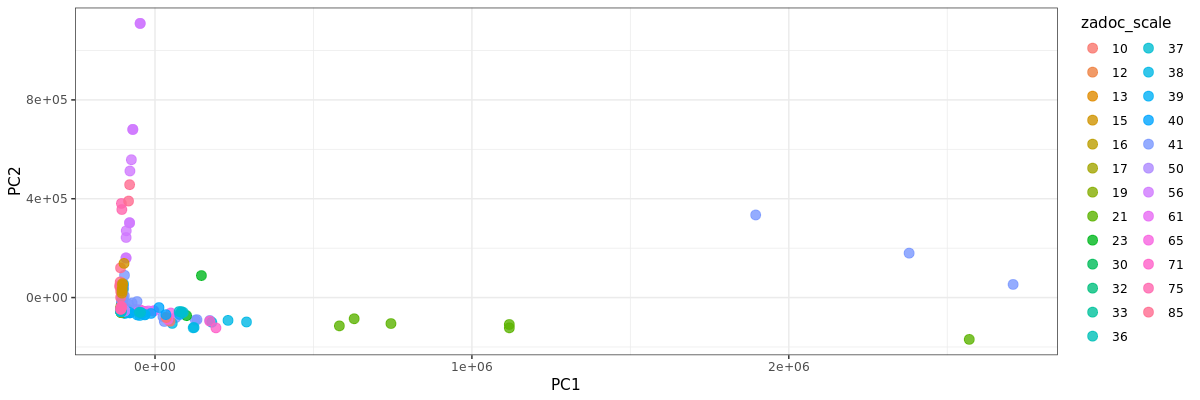

In [60]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower3, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower3, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_flower3, color_by = 'zadoc_scale',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [61]:
# check for bootstrapping
options(repr.plot.width = 15, repr.plot.height = 12, repr.plot.res = 100)
#plot_bootstrap(so_flower3, 'Horvu_MOREX_7H01G200700', color_by = 'zadoc_scale',units='scaled_reads_per_base')

In [63]:
# create models
so_flower3 <- sleuth_fit(so_flower3, ~zadoc_scale + is_flower, 'full')
so_flower3 <- sleuth_fit(so_flower3, ~zadoc_scale, 'reduced')
# singular composition caused by dataset + zadoc_scale -> so I tried excluding dataset, it works in barley
# problem is caused by the fact that some datasets contain only 1-2 kinds of Zadoc-category

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [64]:
# perform DGE test
so_flower3 <- sleuth_lrt(so_flower3, 'reduced', 'full')

In [65]:
models(so_flower3)

[  full  ]
formula:  ~zadoc_scale + is_flower 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	zadoc_scale12
 	zadoc_scale13
 	zadoc_scale15
 	zadoc_scale16
 	zadoc_scale17
 	zadoc_scale19
 	zadoc_scale21
 	zadoc_scale23
 	zadoc_scale30
 	zadoc_scale32
 	zadoc_scale33
 	zadoc_scale36
 	zadoc_scale37
 	zadoc_scale38
 	zadoc_scale39
 	zadoc_scale40
 	zadoc_scale41
 	zadoc_scale50
 	zadoc_scale56
 	zadoc_scale61
 	zadoc_scale65
 	zadoc_scale71
 	zadoc_scale75
 	zadoc_scale85
 	is_floweryes
[  reduced  ]
formula:  ~zadoc_scale 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	zadoc_scale12
 	zadoc_scale13
 	zadoc_scale15
 	zadoc_scale16
 	zadoc_scale17
 	zadoc_scale19
 	zadoc_scale21
 	zadoc_scale23
 	zadoc_scale30
 	zadoc_scale32
 	zadoc_scale33
 	zadoc_scale36
 	zadoc_scale37
 	zadoc_scale38
 	zadoc_scale39
 	zadoc_scale40
 	zadoc_scale41
 	zadoc_scale50
 	zadoc_scale56
 	zadoc_scale61
 	zadoc_scale65
 	zadoc_scale71
 	za

In [66]:
table_flower3 <- sleuth_results(so_flower3, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower3_1 <- filter(table_flower3, qval <= 0.1)
glimpse(sig_flower3_1)
sig_flower3_05 <- filter(table_flower3, qval <= 0.05)
glimpse(sig_flower3_05)
sig_flower3_01 <- filter(table_flower3, qval <= 0.01)
glimpse(sig_flower3_01)
# look at table and few of 0.05
head(sig_flower3_05, 5)

Rows: 56,064
Columns: 12
$ target_id       <chr> "TraesCHI7B01G529000", "TraesCHI1A01G126000", "TraesC…
$ pval            <dbl> 1.444007e-51, 5.050757e-50, 8.901842e-48, 3.257760e-4…
$ qval            <dbl> 8.768155e-47, 1.533435e-45, 1.801763e-43, 4.945360e-4…
$ test_stat       <dbl> 228.2382, 221.1600, 210.8635, 208.2810, 207.0070, 201…
$ rss             <dbl> 376.89752, 168.85009, 158.69629, 195.36356, 316.99174…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 3.730557, 5.439571, 5.310973, 3.721237, 3.117991, 6.5…
$ var_obs         <dbl> 3.4676905, 1.3843657, 1.3401100, 2.2241551, 3.0334691…
$ tech_var        <dbl> 0.076367443, 0.021410147, 0.029789014, 0.042148702, 0…
$ sigma_sq        <dbl> 1.9073037, 0.8672745, 0.8054546, 0.9860805, 1.6039253…
$ smooth_sigma_sq <dbl> 0.5084194, 0.1681584, 0.1780264, 0.5116902, 0.7322716…
$ final_sigma_sq  <dbl> 1.9073037, 0.8672745, 0.8054546, 0.9860805, 1.6039253…
Rows: 55,045
Columns: 12
$ 

target_id           pval         qval         test_stat rss      degrees_free
1 TraesCHI7B01G529000 1.444007e-51 8.768155e-47 228.2382  376.8975 1           
2 TraesCHI1A01G126000 5.050757e-50 1.533435e-45 221.1600  168.8501 1           
3 TraesCHI1D01G129900 8.901842e-48 1.801763e-43 210.8635  158.6963 1           
4 TraesCHI2B01G113900 3.257760e-47 4.945360e-43 208.2810  195.3636 1           
5 TraesCHI3D01G568600 6.178259e-47 7.503002e-43 207.0070  316.9917 1           
  mean_obs var_obs  tech_var   sigma_sq  smooth_sigma_sq final_sigma_sq
1 3.730557 3.467690 0.07636744 1.9073037 0.5084194       1.9073037     
2 5.439571 1.384366 0.02141015 0.8672745 0.1681584       0.8672745     
3 5.310973 1.340110 0.02978901 0.8054546 0.1780264       0.8054546     
4 3.721237 2.224155 0.04214870 0.9860805 0.5116902       0.9860805     
5 3.117991 3.033469 0.06445229 1.6039253 0.7322716       1.6039253

In [67]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig_flower3_1, file = "deg_wheat_flower3_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower3_05, file = "deg_wheat_flower3_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower3_01, file = "deg_wheat_flower3_signif0_01.csv", sep = ",", col.names = TRUE)

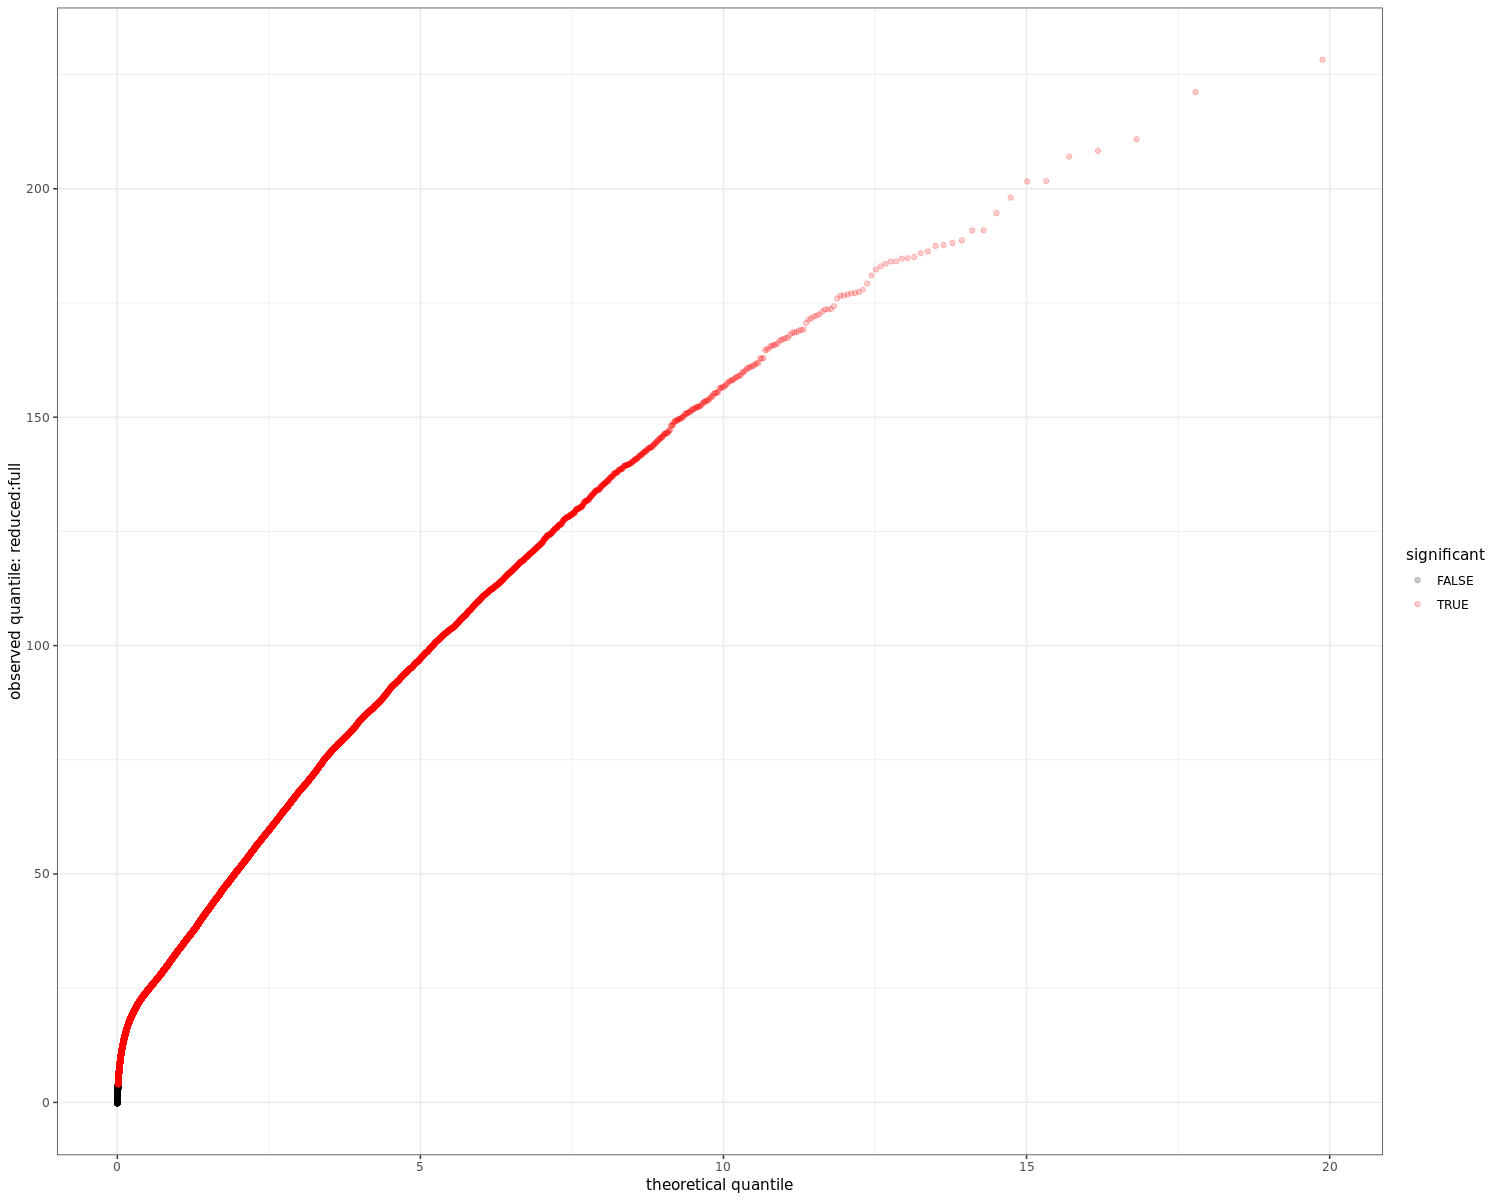

In [68]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_qq(so_flower3, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

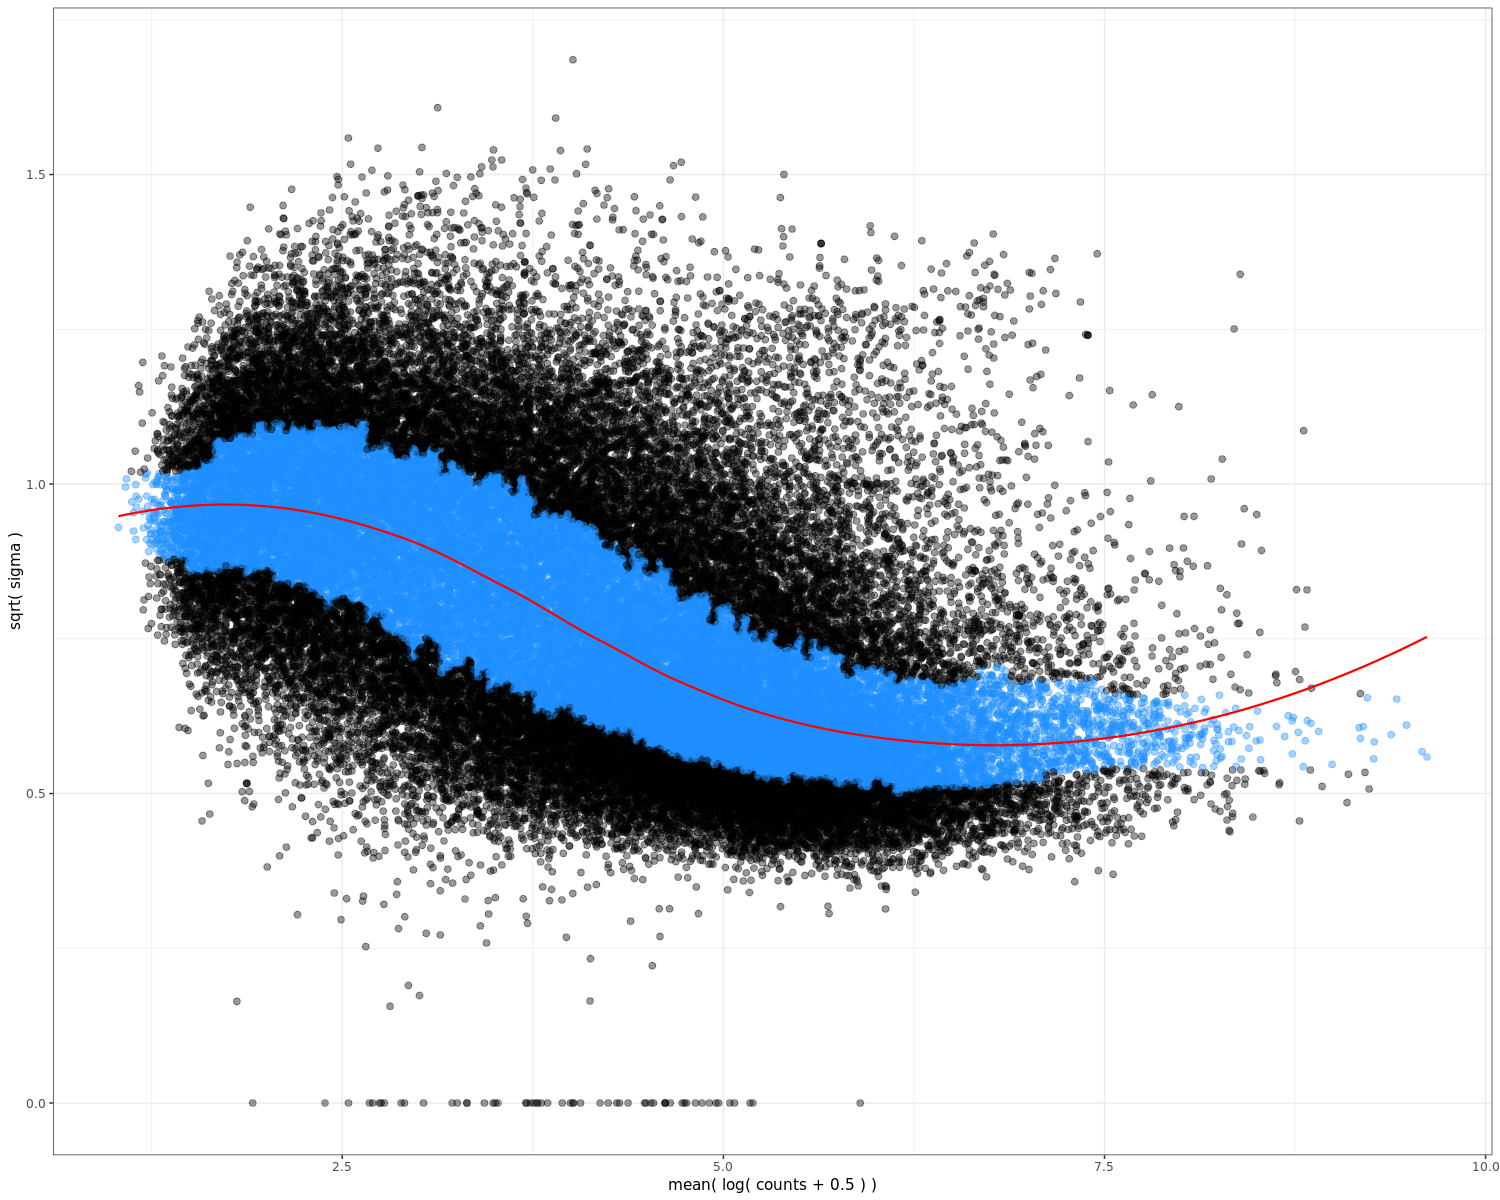

In [69]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_mean_var(so_flower3,which_model="full")

# 4. Flower contrast: **primordiums vs matured flower tissues based on dev.stages**
## 4.1 Create contrast variables
 * **is_primordium:** yes = 13-30Z flower&primordium tissues, no = 31-69Z flower&primordium tissues
 * modells:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`

In [70]:
# here we exclude grain, seedling and root samples from the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- wheat_meta %>% filter(as.character(high_level_tissue) == "inflorescence" | 
                                               as.character(high_level_tissue) == "leaf" | 
                                               as.character(high_level_tissue) == "meristem" | 
                                               as.character(high_level_tissue) == "stem") %>% select(ID, dataset, zadoc_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadoc_scale <= 30 & zadoc_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, dataset, is_primordium)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadoc_scale >= 31 & zadoc_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, dataset, is_primordium)
# here we join tables of primordium stage or not into one
wheat_flower4 <- bind_rows(is_primordium_yes, is_primordium_no)
wheat_flower4$ID <- as.factor(wheat_flower4$ID)
wheat_flower4$dataset <- as.factor(wheat_flower4$dataset)
wheat_flower4$is_primordium <- as.factor(wheat_flower4$is_primordium)
glimpse(is_primordium_tissue)
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
glimpse(wheat_flower4)
tail(wheat_flower4, 3)

Rows: 191
Columns: 3
$ ID          <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR10737430…
$ dataset     <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility…
$ zadoc_scale <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5…
Rows: 32
Columns: 3
$ ID            <chr> "ERR424728", "ERR424748", "ERR424772", "ERR424774", "SR…
$ dataset       <chr> "dev_timecourse_series", "dev_timecourse_series", "dev_…
$ is_primordium <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes",…
Rows: 147
Columns: 3
$ ID            <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR107374…
$ dataset       <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterili…
$ is_primordium <chr> "no", "no", "no", "no", "no", "no", "no", "no", "no", "…
Rows: 179
Columns: 3
$ ID            <fct> ERR424728, ERR424748, ERR424772, ERR424774, SRR3659902,…
$ dataset       <fct> dev_timecourse_series, dev_timecourse_series, dev_timec…
$ is_primordium <fct> yes, yes, yes, yes, yes, y

ID         dataset   is_primordium
177 SRR6802613 spike_dev no           
178 SRR6802614 spike_dev no           
179 SRR6802615 spike_dev no

In [71]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", wheat_flower4$ID, "abundance.h5")
names(files) <- paste0(wheat_flower4$ID)
head(files)
all(file.exists(files))

ERR424728 
 "../04_Kallisto_allreads_symlinked/ERR424728/abundance.h5" 
                                                  ERR424748 
 "../04_Kallisto_allreads_symlinked/ERR424748/abundance.h5" 
                                                  ERR424772 
 "../04_Kallisto_allreads_symlinked/ERR424772/abundance.h5" 
                                                  ERR424774 
 "../04_Kallisto_allreads_symlinked/ERR424774/abundance.h5" 
                                                 SRR3659902 
"../04_Kallisto_allreads_symlinked/SRR3659902/abundance.h5" 
                                                 SRR3659901 
"../04_Kallisto_allreads_symlinked/SRR3659901/abundance.h5"

[1] TRUE

In [72]:
s2c_flower4 <- mutate(wheat_flower4, path = files, sample = ID)
head(s2c_flower4, 3)

ID        dataset               is_primordium
1 ERR424728 dev_timecourse_series yes          
2 ERR424748 dev_timecourse_series yes          
3 ERR424772 dev_timecourse_series yes          
  path                                                     sample   
1 ../04_Kallisto_allreads_symlinked/ERR424728/abundance.h5 ERR424728
2 ../04_Kallisto_allreads_symlinked/ERR424748/abundance.h5 ERR424748
3 ../04_Kallisto_allreads_symlinked/ERR424772/abundance.h5 ERR424772

In [73]:
# construct the sleuth-object
so_flower4 <- sleuth_prep(sample_to_covariates = s2c_flower4, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
...................................................................................................................................................................................
normalizing est_counts
60827 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60827 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
..............................


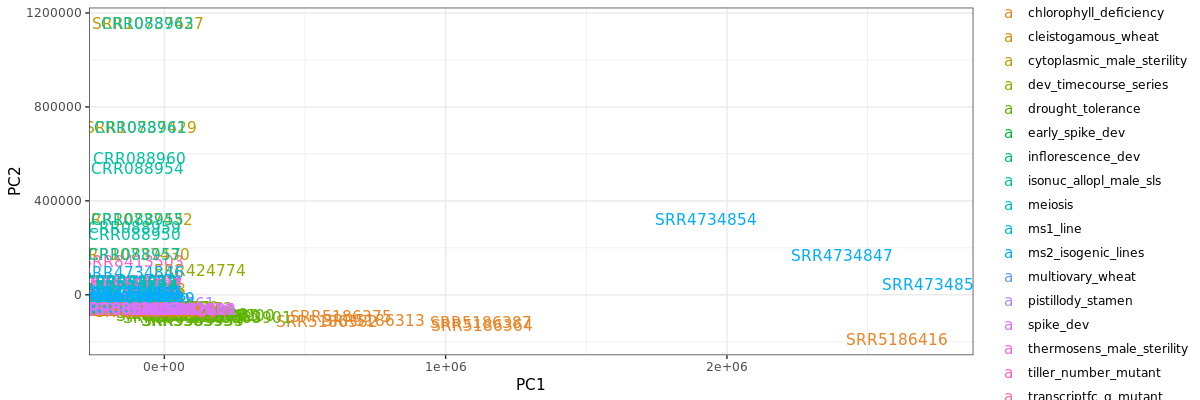

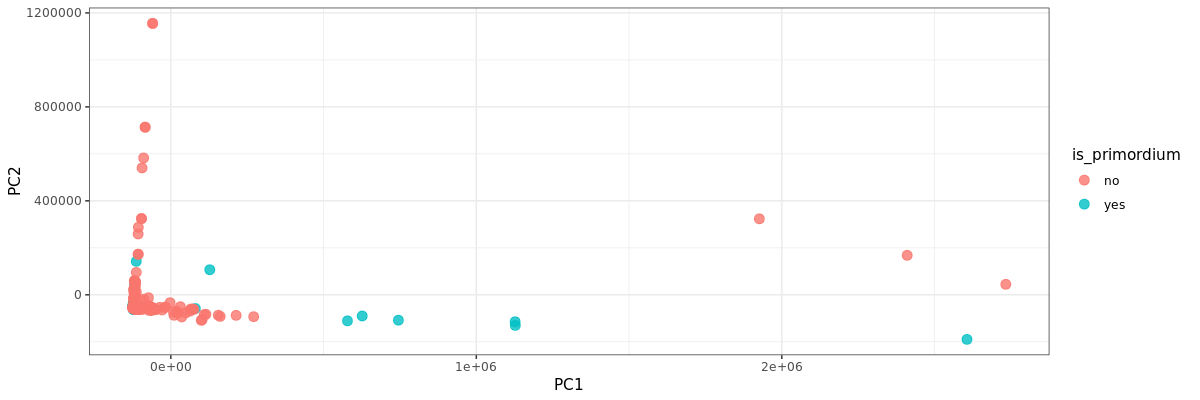

In [74]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower4, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower4, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [75]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
#plot_bootstrap(so_flower4, 'Horvu_MOREX_7H01G200700', color_by = 'is_primordium',units='scaled_reads_per_base')

In [76]:
# create models
so_flower4 <- sleuth_fit(so_flower4, ~dataset + is_primordium, 'full')
so_flower4 <- sleuth_fit(so_flower4, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI4D01G175900, TraesCHI5B01G387700
computing variance of betas
fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI4D01G175900, TraesCHI5B01G387700
computing variance of betas


In [77]:
# perform DGE test
so_flower4 <- sleuth_lrt(so_flower4, 'reduced', 'full')

In [78]:
models(so_flower4)

[  full  ]
formula:  ~dataset + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetmultiovary_wheat
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasetthermosens_male_sterility
 	datasettiller_number_mutant
 	datasettranscriptfc_q_mutant
 	is_primordiumyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetchlorophyll_deficiency
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_l

In [79]:
table_flower4 <- sleuth_results(so_flower4, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower4_1 <- filter(table_flower4, qval <= 0.1)
glimpse(sig_flower4_1)
sig_flower4_05 <- filter(table_flower4, qval <= 0.05)
glimpse(sig_flower4_05)
sig_flower4_01 <- filter(table_flower4, qval <= 0.01)
glimpse(sig_flower4_01)
# look at table and few of 0.05
head(sig_flower4_05, 5)

Rows: 12,401
Columns: 12
$ target_id       <chr> "TraesCHI3A01G583100", "TraesCHI3D01G589700", "TraesC…
$ pval            <dbl> 1.624254e-24, 4.381100e-20, 1.083177e-18, 1.079180e-1…
$ qval            <dbl> 9.879850e-20, 1.332446e-15, 1.647160e-14, 1.647160e-1…
$ test_stat       <dbl> 104.43513, 84.24047, 77.90134, 77.90865, 75.40566, 74…
$ rss             <dbl> 163.91574, 132.21329, 54.72985, 109.11992, 114.28875,…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 4.914588, 4.281714, 6.083402, 4.506084, 4.349555, 5.7…
$ var_obs         <dbl> 2.9024929, 2.9675889, 1.4999785, 4.2207954, 3.3998067…
$ tech_var        <dbl> 0.029147741, 0.043895617, 0.027027051, 0.099160790, 0…
$ sigma_sq        <dbl> 0.98896246, 0.77730493, 0.31290991, 0.57860271, 0.640…
$ smooth_sigma_sq <dbl> 0.10735003, 0.16104523, 0.07065360, 0.13804447, 0.153…
$ final_sigma_sq  <dbl> 0.98896246, 0.77730493, 0.31290991, 0.57860271, 0.640…
Rows: 8,244
Columns: 12
$ t

target_id           pval         qval         test_stat rss      
1 TraesCHI3A01G583100 1.624254e-24 9.879850e-20 104.43513 163.91574
2 TraesCHI3D01G589700 4.381100e-20 1.332446e-15  84.24047 132.21329
3 TraesCHI3D01G255600 1.083177e-18 1.647160e-14  77.90134  54.72985
4 TraesCHI5A01G208100 1.079180e-18 1.647160e-14  77.90865 109.11992
5 TraesCHI2D01G459800 3.832893e-18 4.662868e-14  75.40566 114.28875
  degrees_free mean_obs var_obs  tech_var   sigma_sq  smooth_sigma_sq
1 1            4.914588 2.902493 0.02914774 0.9889625 0.1073500      
2 1            4.281714 2.967589 0.04389562 0.7773049 0.1610452      
3 1            6.083402 1.499978 0.02702705 0.3129099 0.0706536      
4 1            4.506084 4.220795 0.09916079 0.5786027 0.1380445      
5 1            4.349555 3.399807 0.06912301 0.6407450 0.1537782      
  final_sigma_sq
1 0.9889625     
2 0.7773049     
3 0.3129099     
4 0.5786027     
5 0.6407450

In [80]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig_flower4_1, file = "deg_wheat_flower4_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower4_05, file = "deg_wheat_flower4_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower4_01, file = "deg_wheat_flower4_signif0_01.csv", sep = ",", col.names = TRUE)

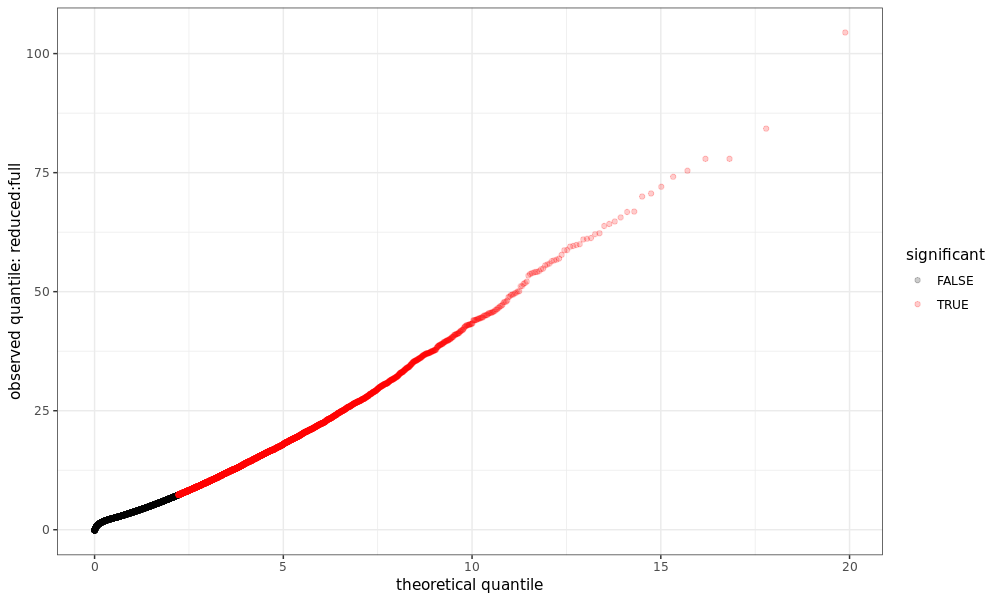

In [81]:
plot_qq(so_flower4, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

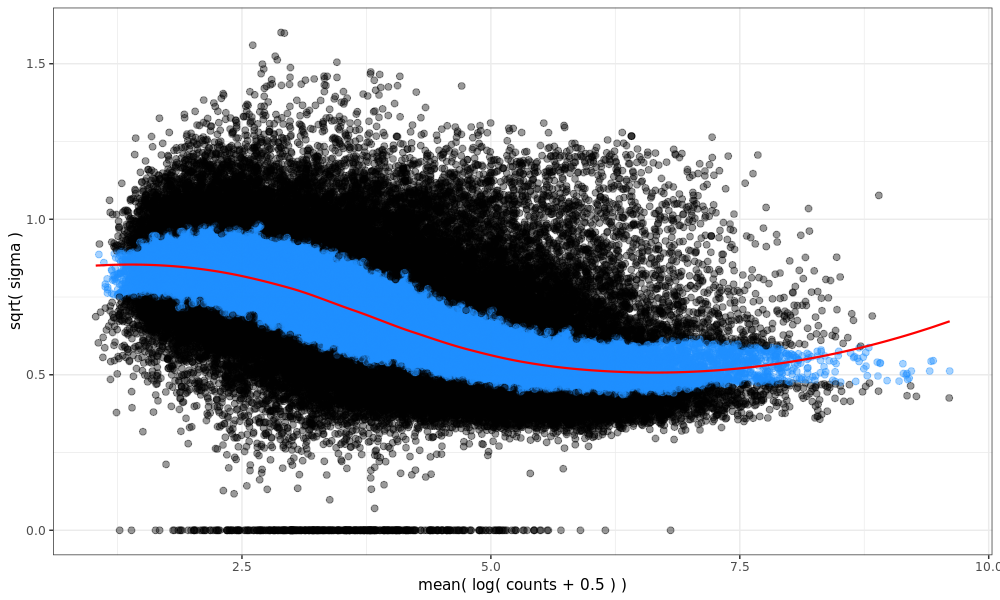

In [82]:
plot_mean_var(so_flower4,which_model="full")

# 5. Flower contrast: **primordiums vs matured flower tissues based on dev.stages**
## 5.1 Create contrast variables
 * **is_primordium:** yes = 13-30Z flower tissues, no = 31-69Z flower tissues
 * modells:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`

In [83]:
# here we exclude grain, seedling and root samples from the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- wheat_meta %>% filter(as.character(high_level_tissue) == "inflorescence") %>% select(ID, dataset, zadoc_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadoc_scale <= 30 & zadoc_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, dataset, is_primordium)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadoc_scale >= 31 & zadoc_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, dataset, is_primordium)
# here we join tables of primordium stage or not into one
wheat_flower5 <- bind_rows(is_primordium_yes, is_primordium_no)
wheat_flower5$ID <- as.factor(wheat_flower5$ID)
wheat_flower5$dataset <- as.factor(wheat_flower5$dataset)
wheat_flower5$is_primordium <- as.factor(wheat_flower5$is_primordium)
glimpse(is_primordium_tissue)
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
glimpse(wheat_flower5)
tail(wheat_flower5, 3)

Rows: 151
Columns: 3
$ ID          <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR10737430…
$ dataset     <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility…
$ zadoc_scale <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5…
Rows: 16
Columns: 3
$ ID            <chr> "SRR3659902", "SRR3659901", "SRR3659900", "SRR3659899",…
$ dataset       <chr> "early_spike_dev", "early_spike_dev", "early_spike_dev"…
$ is_primordium <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes",…
Rows: 127
Columns: 3
$ ID            <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR107374…
$ dataset       <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterili…
$ is_primordium <chr> "no", "no", "no", "no", "no", "no", "no", "no", "no", "…
Rows: 143
Columns: 3
$ ID            <fct> SRR3659902, SRR3659901, SRR3659900, SRR3659899, SRR3659…
$ dataset       <fct> early_spike_dev, early_spike_dev, early_spike_dev, earl…
$ is_primordium <fct> yes, yes, yes, yes, yes, y

ID         dataset   is_primordium
141 SRR6802613 spike_dev no           
142 SRR6802614 spike_dev no           
143 SRR6802615 spike_dev no

In [84]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", wheat_flower5$ID, "abundance.h5")
names(files) <- paste0(wheat_flower5$ID)
head(files)
all(file.exists(files))

SRR3659902 
"../04_Kallisto_allreads_symlinked/SRR3659902/abundance.h5" 
                                                 SRR3659901 
"../04_Kallisto_allreads_symlinked/SRR3659901/abundance.h5" 
                                                 SRR3659900 
"../04_Kallisto_allreads_symlinked/SRR3659900/abundance.h5" 
                                                 SRR3659899 
"../04_Kallisto_allreads_symlinked/SRR3659899/abundance.h5" 
                                                 SRR3659898 
"../04_Kallisto_allreads_symlinked/SRR3659898/abundance.h5" 
                                                 SRR3659897 
"../04_Kallisto_allreads_symlinked/SRR3659897/abundance.h5"

[1] TRUE

In [85]:
s2c_flower5 <- mutate(wheat_flower5, path = files, sample = ID)
head(s2c_flower5, 3)

ID         dataset         is_primordium
1 SRR3659902 early_spike_dev yes          
2 SRR3659901 early_spike_dev yes          
3 SRR3659900 early_spike_dev yes          
  path                                                      sample    
1 ../04_Kallisto_allreads_symlinked/SRR3659902/abundance.h5 SRR3659902
2 ../04_Kallisto_allreads_symlinked/SRR3659901/abundance.h5 SRR3659901
3 ../04_Kallisto_allreads_symlinked/SRR3659900/abundance.h5 SRR3659900

In [86]:
# construct the sleuth-object
so_flower5 <- sleuth_prep(sample_to_covariates = s2c_flower5, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
...............................................................................................................................................
normalizing est_counts
60161 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
60161 genes passed the filter
summarizing bootstraps
.................................................
..................................................
............................................


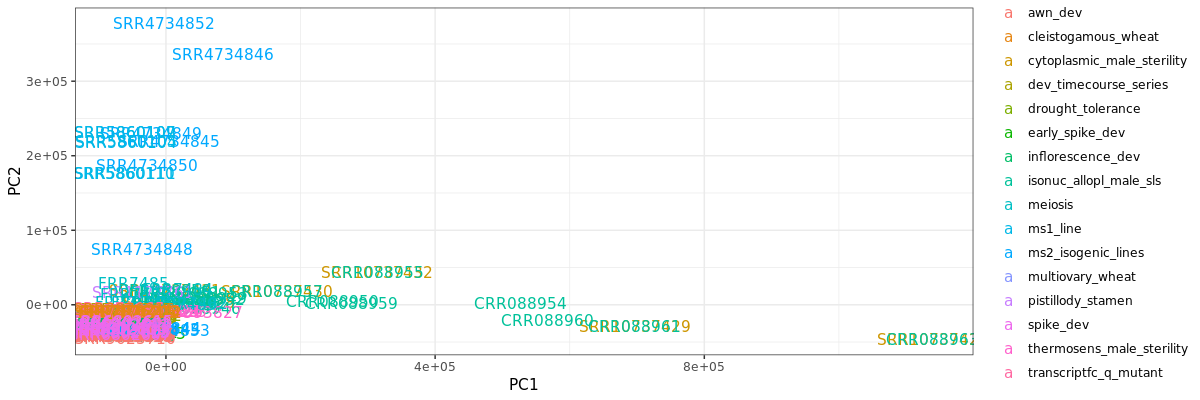

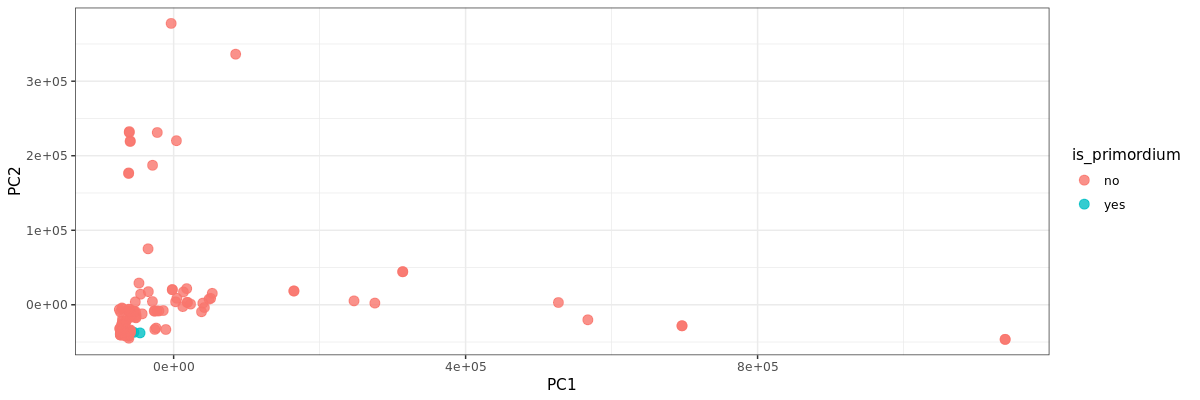

In [87]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower5, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower5, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [88]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
#plot_bootstrap(so_flower5, 'Horvu_MOREX_7H01G200700', color_by = 'is_primordium',units='scaled_reads_per_base')

In [89]:
# create models
so_flower5 <- sleuth_fit(so_flower5, ~dataset + is_primordium, 'full')
so_flower5 <- sleuth_fit(so_flower5, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
4 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI3D01G437300, TraesCHI4D01G175900, TraesCHIUn01G304400, TraesCHI1A01G385200
computing variance of betas
fitting measurement error models
shrinkage estimation
4 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI3D01G437300, TraesCHI4D01G175900, TraesCHIUn01G304400, TraesCHI1A01G385200
computing variance of betas


In [90]:
# perform DGE test
so_flower5 <- sleuth_lrt(so_flower5, 'reduced', 'full')

In [91]:
models(so_flower5)

[  full  ]
formula:  ~dataset + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetmultiovary_wheat
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasetthermosens_male_sterility
 	datasettranscriptfc_q_mutant
 	is_primordiumyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetmultiovary_wheat
 	datasetpistillody_stamen
 	dataset

In [92]:
table_flower5 <- sleuth_results(so_flower5, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower5_1 <- filter(table_flower5, qval <= 0.1)
glimpse(sig_flower5_1)
sig_flower5_05 <- filter(table_flower5, qval <= 0.05)
glimpse(sig_flower5_05)
sig_flower5_01 <- filter(table_flower5, qval <= 0.01)
glimpse(sig_flower5_01)
# look at table and few of 0.05
head(sig_flower5_05, 5)

Rows: 15,635
Columns: 12
$ target_id       <chr> "TraesCHI6D01G446800", "TraesCHI2D01G459800", "TraesC…
$ pval            <dbl> 1.911022e-29, 1.669159e-25, 2.598066e-21, 4.234512e-2…
$ qval            <dbl> 1.149690e-24, 5.020913e-21, 5.210075e-17, 6.368812e-1…
$ test_stat       <dbl> 126.94388, 108.94424, 89.82788, 88.86147, 87.78587, 8…
$ rss             <dbl> 80.41064, 62.21031, 111.46171, 41.16335, 62.42263, 85…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 4.575585, 4.462452, 4.009796, 5.127844, 4.531032, 3.4…
$ var_obs         <dbl> 1.895029, 2.815442, 4.068253, 1.898008, 2.157149, 3.4…
$ tech_var        <dbl> 0.03181741, 0.03924410, 0.06339597, 0.03881143, 0.040…
$ sigma_sq        <dbl> 0.6013372, 0.4506009, 0.8142553, 0.2853094, 0.4514505…
$ smooth_sigma_sq <dbl> 0.09927908, 0.10621565, 0.14170177, 0.07565531, 0.101…
$ final_sigma_sq  <dbl> 0.6013372, 0.4506009, 0.8142553, 0.2853094, 0.4514505…
Rows: 11,325
Columns: 12
$ 

target_id           pval         qval         test_stat rss      
1 TraesCHI6D01G446800 1.911022e-29 1.149690e-24 126.94388  80.41064
2 TraesCHI2D01G459800 1.669159e-25 5.020913e-21 108.94424  62.21031
3 TraesCHI4D01G194600 2.598066e-21 5.210075e-17  89.82788 111.46171
4 TraesCHI2B01G410400 4.234512e-21 6.368812e-17  88.86147  41.16335
5 TraesCHI2A01G077900 7.293821e-21 7.313393e-17  87.78587  62.42263
  degrees_free mean_obs var_obs  tech_var   sigma_sq  smooth_sigma_sq
1 1            4.575585 1.895029 0.03181741 0.6013372 0.09927908     
2 1            4.462452 2.815442 0.03924410 0.4506009 0.10621565     
3 1            4.009796 4.068253 0.06339597 0.8142553 0.14170177     
4 1            5.127844 1.898008 0.03881143 0.2853094 0.07565531     
5 1            4.531032 2.157149 0.04006628 0.4514505 0.10191663     
  final_sigma_sq
1 0.6013372     
2 0.4506009     
3 0.8142553     
4 0.2853094     
5 0.4514505

In [93]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig_flower5_1, file = "deg_wheat_flower5_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower5_05, file = "deg_wheat_flower5_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower5_01, file = "deg_wheat_flower5_signif0_01.csv", sep = ",", col.names = TRUE)

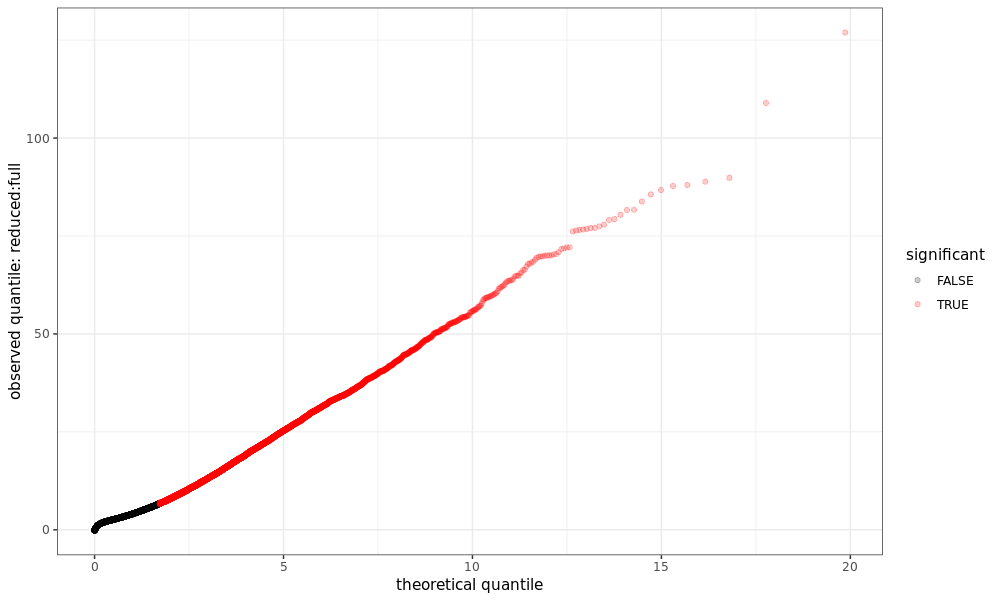

In [94]:
plot_qq(so_flower5, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

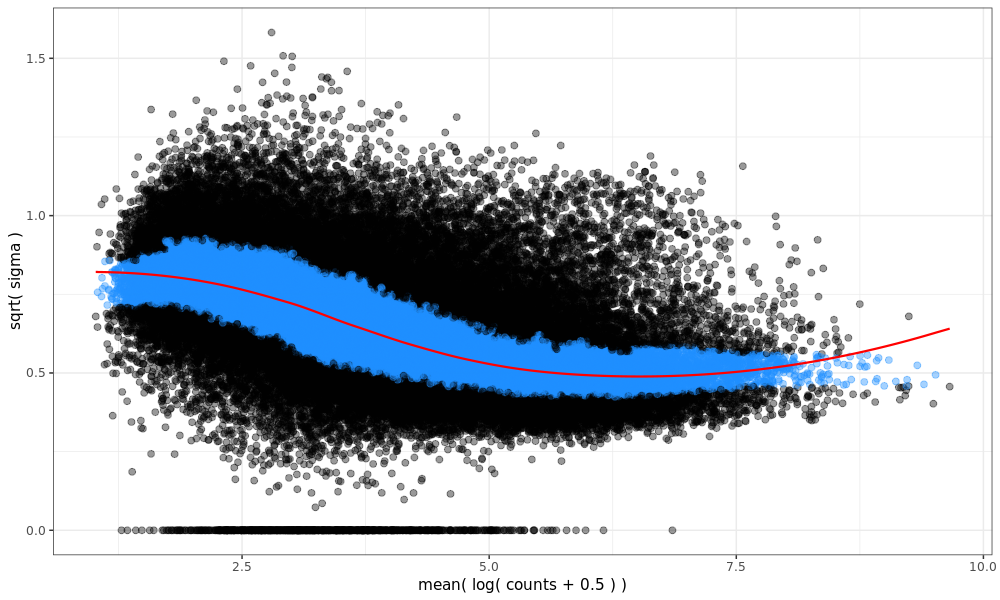

In [95]:
plot_mean_var(so_flower5,which_model="full")

In [176]:
sleuth_live_settings(test_type = "lrt")
sleuth_live(so_flower1, settings = sleuth_live_settings())
# in order to display: open new terminal tab and type: `ssh -L localhost:42427:localhost:42427 vanda.marosi@bee`
# number after localhost has to match the last number written in the output
# after this, copy and enter http site address 

$test_type
[1] "lrt"


Listening on http://127.0.0.1:42427


In [98]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] shiny_1.3.2         pheatmap_1.0.12     vsn_3.54.0         
 [4] Biobase_2.46.0      BiocGenerics_0.32.0 RColorBrewer_1.1-2 
 [7] cowplot_1.0.0       forcats_0.5.0       stringr_1.4.0      
[10] dplyr_0.8.5         purrr_0.3.4         readr_1.3.1        
[13] tidyr_1.0.2       